1. Importing

In [16]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

2. Parameter

In [17]:
r=102316104
file="data.csv"
epochs=5000
batch_size=128
lr=0.0002
num_samples_pdf=10000
device="cpu"

3. Loading Dataset

In [18]:
data=pd.read_csv(file,encoding="latin1")
x=data["no2"].dropna().astype(np.float32)


C:\Users\Aashishsharma\AppData\Local\Temp\ipykernel_17904\168529.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv(file,encoding="latin1")


4. Normalise and Transform

In [19]:
x=(x-x.mean())/x.std()
ar=0.5*(r%7)
br=0.3*((r%5)+1)
z=x+ar*np.sin(br*x)
z=z.to_numpy().reshape(-1,1)
print("Transformation parameter : ",ar,",",br)

Transformation parameter :  1.0 , 1.5


5. GAN Models

In [20]:
tensor_z=torch.tensor(z)
dataset=TensorDataset(tensor_z)
loader=DataLoader(dataset,batch_size,shuffle=True)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(nn.Linear(1,64),nn.ReLU(),nn.Linear(64,64),nn.ReLU(),nn.Linear(64,1))
    def forward(self,x):
        return self.net(x)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(nn.Linear(1,64),nn.ReLU(),nn.Linear(64,64),nn.ReLU(),nn.Linear(64,1),nn.Sigmoid())
    def forward(self,x):
        return self.net(x)
G=Generator().to(device)
D=Discriminator().to(device)
criterion=nn.BCELoss()
opt_G=torch.optim.Adam(G.parameters(),lr=lr)
opt_D=torch.optim.Adam(D.parameters(),lr=lr)


6. Train GAN

In [21]:
for epoch in range(epochs):
    real_z,=next(iter(loader))
    real_z=real_z.to(device)
    batch=real_z.size(0)
    noise=torch.randn(batch,1).to(device)
    fake_z=G(noise)
    loss_D=(criterion(D(real_z),torch.ones(batch,1).to(device))+criterion(D(fake_z.detach()),torch.zeros(batch,1).to(device)))
    opt_D.zero_grad()
    loss_D.backward()
    opt_D.step()
    noise=torch.randn(batch,1).to(device)
    fake_z=G(noise)
    loss_G=criterion(D(fake_z),torch.ones(batch,1).to(device))
    opt_G.zero_grad()
    loss_G.backward()
    opt_G.step()

    if(epoch%200==0):
        print(f"Epoch {epoch} | D: {loss_D.item():.3f} | G: {loss_G.item():.3f}")




Epoch 0 | D: 1.404 | G: 0.652
Epoch 200 | D: 1.255 | G: 0.595
Epoch 400 | D: 1.389 | G: 0.869
Epoch 600 | D: 1.367 | G: 0.676
Epoch 800 | D: 1.363 | G: 0.723
Epoch 1000 | D: 1.383 | G: 0.681
Epoch 1200 | D: 1.386 | G: 0.689
Epoch 1400 | D: 1.381 | G: 0.746
Epoch 1600 | D: 1.428 | G: 0.793
Epoch 1800 | D: 1.377 | G: 0.729
Epoch 2000 | D: 1.379 | G: 0.654
Epoch 2200 | D: 1.381 | G: 0.686
Epoch 2400 | D: 1.398 | G: 0.729
Epoch 2600 | D: 1.395 | G: 0.679
Epoch 2800 | D: 1.370 | G: 0.710
Epoch 3000 | D: 1.417 | G: 0.721
Epoch 3200 | D: 1.384 | G: 0.726
Epoch 3400 | D: 1.380 | G: 0.677
Epoch 3600 | D: 1.385 | G: 0.729
Epoch 3800 | D: 1.381 | G: 0.673
Epoch 4000 | D: 1.397 | G: 0.646
Epoch 4200 | D: 1.390 | G: 0.715
Epoch 4400 | D: 1.375 | G: 0.702
Epoch 4600 | D: 1.380 | G: 0.671
Epoch 4800 | D: 1.386 | G: 0.684


7. Generate Sample

In [22]:
G.eval()
with torch.no_grad():
    noise=torch.randn(num_samples_pdf,1).to(device)
    z_fake=G(noise).cpu().numpy().flatten()

8. PDF Estimation

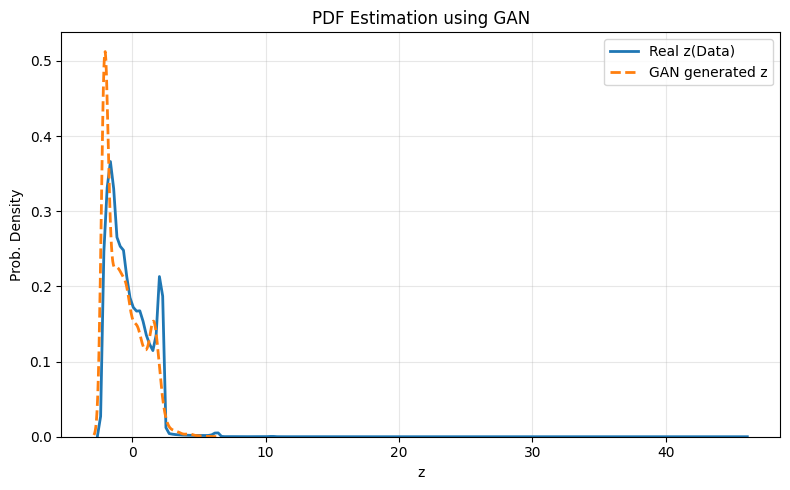

In [24]:
plt.figure(figsize=(8,5))
sns.kdeplot(z.flatten(),label="Real z(Data)",linewidth=2)
sns.kdeplot(z_fake,label="GAN generated z",linestyle="--",linewidth=2)
plt.xlabel("z")
plt.ylabel("Prob. Density")
plt.title("PDF Estimation using GAN")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("gan_pdf_estimation.jpg",dpi=300)
plt.show()